In [1]:
from itertools import product

import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import multiprocessing
from scipy import integrate
from scipy.stats import norm
import mpmath
from scipy.optimize import minimize
from optimparallel import minimize_parallel

from fairpair import *

In [2]:
from workers import *

## Chance of Winning

In [87]:
scores = np.arange(0.01,1.01,0.01)
scores_ij = np.array(list(product(scores, scores)))
probs = pd.DataFrame(scores_ij, columns=['i\'s score', 'j\'s score'])
probs

,i's score,j's score
0,0.01,0.01
1,0.01,0.02
2,0.01,0.03
3,0.01,0.04
4,0.01,0.05
...,...,...
9995,1.00,0.96
9996,1.00,0.97
9997,1.00,0.98
9998,1.00,0.99


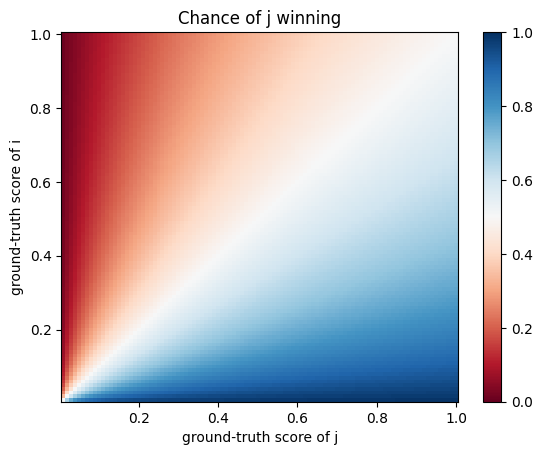

In [88]:
BTL_probs = probs.copy()
BTL_probs['prob j winning'] = BTL_probs['j\'s score'] / (BTL_probs['i\'s score'] + BTL_probs['j\'s score'])

fig, ax = plt.subplots()
c = ax.pcolormesh(scores, scores, np.array(BTL_probs['prob j winning']).reshape(100, 100), cmap='RdBu', vmin=0, vmax=1)
ax.set_title('Chance of j winning')
ax.set_xlabel('ground-truth score of j')
ax.set_ylabel('ground-truth score of i')
fig.colorbar(c, ax=ax)
plt.show()

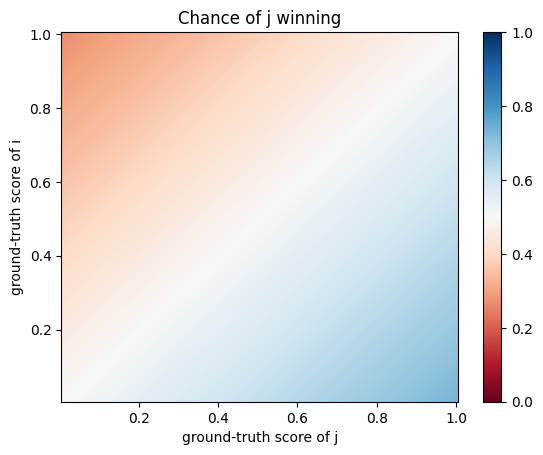

In [89]:
BTL_probs = probs.copy()
BTL_probs['prob j winning'] = np.exp(BTL_probs['j\'s score']) / (np.exp(BTL_probs['i\'s score']) + np.exp(BTL_probs['j\'s score']))
#min_prob = min(BTL_probs['prob j winning'])
#max_prob = max(BTL_probs['prob j winning'])
#BTL_probs['prob j winning'] = (BTL_probs['prob j winning'] - min_prob)/(max_prob - min_prob)

fig, ax = plt.subplots()
c = ax.pcolormesh(scores, scores, np.array(BTL_probs['prob j winning']).reshape(100, 100), cmap='RdBu', vmin=0, vmax=1)
ax.set_title('Chance of j winning')
ax.set_xlabel('ground-truth score of j')
ax.set_ylabel('ground-truth score of i')
fig.colorbar(c, ax=ax)
plt.show()

## Range of Scores

In [111]:
scores = np.arange(0,10,0.01)
scores_ij = np.array(list(product(scores, scores)))
probs = pd.DataFrame(scores_ij, columns=['i\'s score', 'j\'s score'])

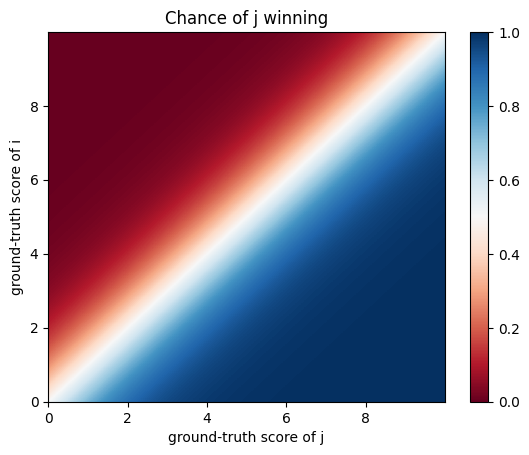

In [112]:
BTL_probs = probs.copy()
BTL_probs['prob j winning'] = np.exp(BTL_probs['j\'s score']) / (np.exp(BTL_probs['i\'s score']) + np.exp(BTL_probs['j\'s score']))
#min_prob = min(BTL_probs['prob j winning'])
#max_prob = max(BTL_probs['prob j winning'])
#BTL_probs['prob j winning'] = (BTL_probs['prob j winning'] - min_prob)/(max_prob - min_prob)

fig, ax = plt.subplots()
c = ax.pcolormesh(scores, scores, np.array(BTL_probs['prob j winning']).reshape(1000, 1000), cmap='RdBu', vmin=0, vmax=1)
ax.set_title('Chance of j winning')
ax.set_xlabel('ground-truth score of j')
ax.set_ylabel('ground-truth score of i')
fig.colorbar(c, ax=ax)
plt.show()

## Range of Scores vs. Iterations

In [17]:
score_range = [1, 2, 5, 10, 20, 50]
tasks = list(product(range(10), score_range))

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    accuracy = pool.starmap(get_score_range, tasks)
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iterations', 'range of scores', 'Weighted Kendall tau'])
    accuracy

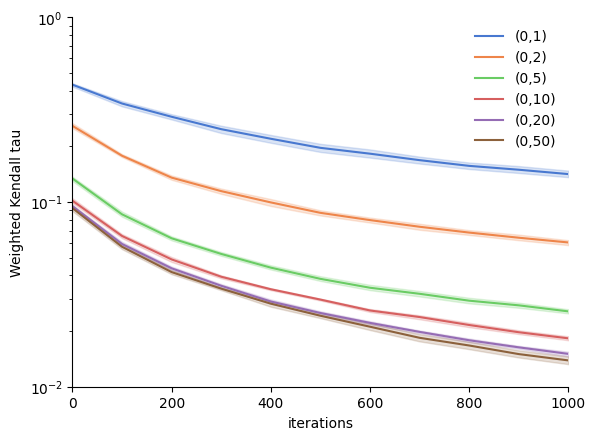

In [34]:
#palette = sns.color_palette()
#palette[2] = palette[7]
#with sns.color_palette(palette):
accuracy['Scores in'] = [f'(0,{score})' for score in accuracy['range of scores']]
ax = sns.lineplot(accuracy, x='iterations', y='Weighted Kendall tau', hue='Scores in', palette='muted')
ax.legend(frameon=False)
ax.set(ylim=(0.01,1), xlim=(0,1000), yscale='log')
sns.despine()

## Confidence in Winning

In [57]:
scores = np.logspace(-1,1,num=100)
probs = pd.DataFrame(scores, columns=['difference in scores'])
probs['confidence in winning'] = np.exp(probs['difference in scores']) / (1 + np.exp(probs['difference in scores']))
probs['type'] = 'maximal chance'

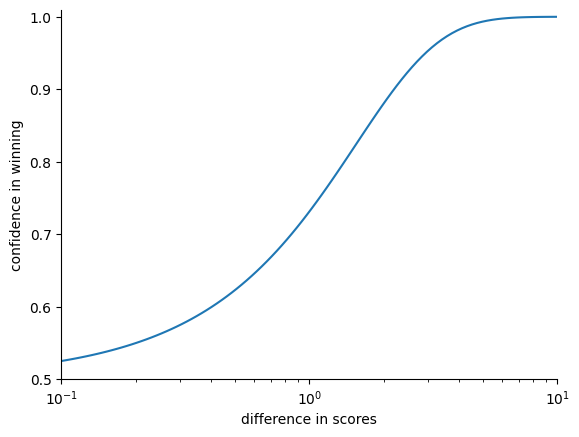

In [58]:
ax = sns.lineplot(probs, x='difference in scores', y='confidence in winning')
ax.set(ylim=(0.5,1.01), xlim=(0.1,10), xscale='log')
sns.despine()

In [140]:
#scores = np.arange(0,12.6,0.01)
#scores_ij = np.array(list(product(scores, scores)))
rng = np.random.default_rng()
scores_i = rng.uniform(low=0, high=3, size=100000000)
scores_j = rng.uniform(low=0, high=3, size=100000000)
probs = pd.DataFrame(np.matrix([scores_i, scores_j]).transpose(), columns=['i\'s score', 'j\'s score'])
probs['prob j winning'] = np.exp(probs['j\'s score']) / (np.exp(probs['i\'s score']) + np.exp(probs['j\'s score']))
probs['prob i winning'] = 1-probs['prob j winning']
probs['prob stronger winning'] = probs[['prob i winning', 'prob j winning']].max(axis=1)
probs['prob stronger winning'].mean()

0.7097537599453804

In [3]:
# for uniform distributions in [0,L]
probs = []
for L in np.arange(0.1,30.1,0.1):
    f = lambda y, x: np.exp(y)/(np.exp(x) + np.exp(y))
    out, error = integrate.dblquad(f, 0, L, lambda x:x, L)
    out = 2/(L**2)*out # symmetric, so times 2; 1/L^2 is joint probability density
    probs.append((L, out, error))
probs = pd.DataFrame(probs, columns=['range limit', 'prob of stronger candidate winning', 'integral error'])
probs

,range limit,prob of stronger candidate winning,integral error
0,0.1,0.508331,5.677180e-16
1,0.2,0.516650,1.162991e-15
2,0.3,0.524944,1.785615e-15
3,0.4,0.533201,2.435254e-15
4,0.5,0.541409,3.111446e-15
...,...,...,...
295,29.6,0.955043,2.013085e-06
296,29.7,0.955188,2.069332e-06
297,29.8,0.955332,2.125445e-06
298,29.9,0.955476,2.181337e-06


In [30]:
def fast_uniform(L=5):
    (np.pi**2)/12 + L*np.log(2) + mpmath.fp.polylog(2,-np.exp(L))

In [5]:
%timeit integrate.dblquad(f, 0, 5, lambda x:x, 5)

542 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%timeit fast_uniform()

5.65 µs ± 60.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


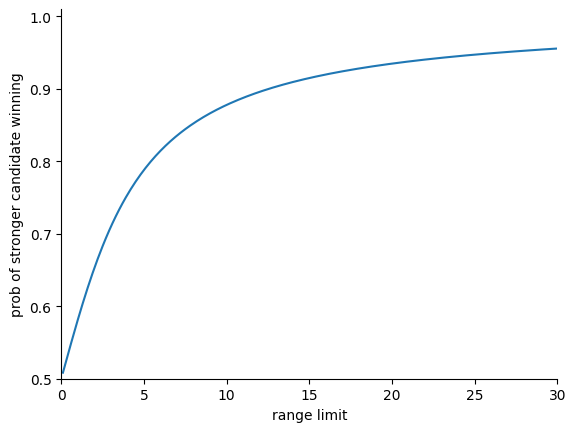

In [4]:
ax = sns.lineplot(probs, x='range limit', y='prob of stronger candidate winning')
ax.set(ylim=(0.5,1.01), xlim=(0,30))
sns.despine()

In [214]:
if __name__ == '__main__':
    pool = multiprocessing.Pool()
    probs_norm = pool.map(get_winning_prob, np.arange(0.5,10.1,0.1))
    probs_norm = [result for pool in probs_norm for result in pool]
    probs_norm = pd.DataFrame(probs_norm, columns=['sigma', 'prob of stronger candidate winning', 'integral error'])

/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [215]:
probs_norm

,sigma,prob of stronger candidate winning,integral error
0,0.5,0.631127,1.276822e-08
1,0.6,0.653130,1.480803e-08
2,0.7,0.673473,1.456773e-08
3,0.8,0.692207,1.314325e-08
4,0.9,0.709419,1.310481e-08
...,...,...,...
91,9.6,0.959546,1.484069e-08
92,9.7,0.959958,1.450650e-08
93,9.8,0.960361,1.431772e-08
94,9.9,0.960756,1.467459e-08


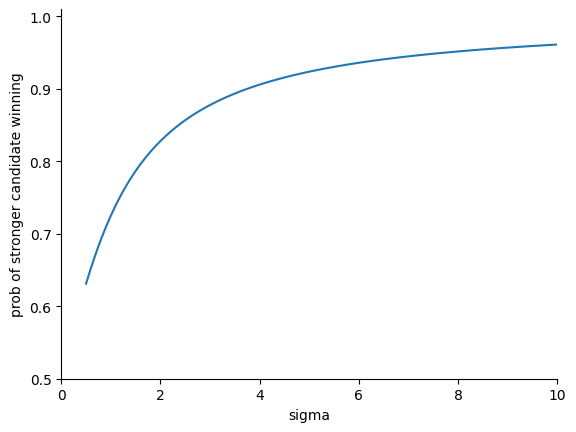

In [216]:
ax = sns.lineplot(probs_norm, x='sigma', y='prob of stronger candidate winning')
ax.set(ylim=(0.5,1.01), xlim=(0,10))
sns.despine()

## Optimizing Parameter Search

In [2]:
prob = 0.9 # desired probability
def prob_uniform(x):
    return (-2)/(x[0]**2)*((np.pi**2)/12 + x[0]*np.log(2) + mpmath.fp.polylog(2,-np.exp(x[0])))
minimize(lambda x: abs(prob_uniform(x)-prob), x0=[1], tol=0.0000001, bounds=[(0.001,1000)]).x[0]

12.552506569731968

In [116]:
prob = 0.9 # desired probability

def prob_normal(sigma):
    f = lambda y, x: 1/(1 + np.exp(x-y))*norm.pdf(x=x, scale=sigma)*norm.pdf(x=y, scale=sigma) # softmax, but less prone to overflow
    out, error = integrate.dblquad(f, -500, 500, lambda x:x, 500)
    return 2*out

minimize(lambda x: abs(prob_normal(x)-prob), x0=[1], tol=0.001, bounds=[(0.001,1000)])

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.186535042671196e-07
        x: [ 3.747e+00]
      nit: 6
      jac: [-2.458e-02]
     nfev: 34
     njev: 17
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

### Prob. of Majority Winning

In [6]:
########  This implementation is most likely WRONG!!!  ########
# It ignores between-group comparisons and relative group sizes

def fast_maj_prob_uniform(maj=6, min=4):
    return - mpmath.fp.polylog(2,-np.exp(-min)) + mpmath.fp.polylog(2,-np.exp(maj-min)) - mpmath.fp.polylog(2,-np.exp(maj)) - (np.pi**2)/12
# same as prob_uniform(), but allows for different ranges
def fast_stronger_prob_uniform(maj=6, min=4):
    return mpmath.fp.polylog(2,-np.exp(maj-min)) - mpmath.fp.polylog(2,-np.exp(maj)) - min*np.log(2)
def loss_uniform(x, prob_maj, prob_stronger):
    maj, min = (x[0], x[1])
    stronger_result = 2*fast_stronger_prob_uniform(maj, min)/(maj*min)
    maj_result = fast_maj_prob_uniform(maj, min)/(maj*min)
    return np.linalg.norm(np.array([prob_maj, prob_stronger] - np.array([maj_result, stronger_result])))

In [11]:
# joint optimization
result = minimize(loss_uniform, x0=[10]*2, args=(0.8, 0.9), tol=0.000000001, bounds=[(0.001,100)]*2)
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.21872946014643374
        x: [ 3.714e+00  2.756e+00]
      nit: 9
      jac: [-2.977e-02  4.013e-02]
     nfev: 72
     njev: 24
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [14]:
maj = result.x[0]
mino = result.x[1]
print(fast_maj_prob_uniform(maj, mino)/(maj*mino))
print(2*fast_stronger_prob_uniform(maj, mino)/(maj*mino))

0.5867861519391925
0.9488101601211594


## Separate Parameters for each Group

In [11]:
### uniform distributions ###
# args are: prob of majority candidate winning, prob of stronger candidate winning

x = minimize_parallel(get_uniform_loss, x0=[5,5], args=(0.7, 0.9), bounds=[(0.1,100)]*2).x
x

array([12.94643681,  7.55136881])

In [10]:
### sanity check – simulate using the parameters obtained from optimization

ratio = 0.2
rng = np.random.default_rng()
scores_min = rng.uniform(low=0, high=x[1], size=int(10000000*ratio))
scores_maj = rng.uniform(low=0, high=x[0], size=int(10000000*(1-ratio)))
scores_i = np.concatenate([scores_min, scores_maj])
#rng.shuffle(scores_i)
scores_j = scores_i.copy()
rng.shuffle(scores_j)
probs = pd.DataFrame(np.matrix([scores_i, scores_j]).transpose(), columns=['i\'s score', 'j\'s score'])
probs['prob j winning'] = np.exp(probs['j\'s score']) / (np.exp(probs['i\'s score']) + np.exp(probs['j\'s score']))
probs['prob i winning'] = 1-probs['prob j winning']
probs['prob stronger winning'] = probs[['prob i winning', 'prob j winning']].max(axis=1)
print('prob of stronger candidate winning:', probs['prob stronger winning'].mean())

scores_min = rng.uniform(low=0, high=x[1], size=int(10000000))
scores_maj = rng.uniform(low=0, high=x[0], size=int(10000000))
probs = pd.DataFrame(np.matrix([scores_min, scores_maj]).transpose(), columns=['min\'s score', 'maj\'s score'])
probs['prob maj winning'] = np.exp(probs['maj\'s score']) / (np.exp(probs['min\'s score']) + np.exp(probs['maj\'s score']))
print('prob of majority candidate winning:', probs['prob maj winning'].mean())

prob of stronger candidate winning: 0.9000382601126976
prob of majority candidate winning: 0.6999086285975072


In [27]:
### normal distributions ###
# args are: prob of majority candidate winning, prob of stronger candidate winning

# number of effective workers is limited by dimensionality of the problem (in this case: 4+1=5)
x = minimize_parallel(get_normal_loss, x0=[0,1,0,1], args=(0.7, 0.9), bounds=[(0.1,10)]*4).x
x

/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225:

array([3.47838355, 4.29150965, 0.98252321, 1.03045846])

In [28]:
### sanity check – simulate using the parameters obtained from optimization

ratio = 0.2
rng = np.random.default_rng()
scores_min = rng.normal(loc=x[2], scale=x[3], size=int(10000000*ratio))
scores_maj = rng.normal(loc=x[0], scale=x[1], size=int(10000000*(1-ratio)))
scores_i = np.concatenate([scores_min, scores_maj])
#rng.shuffle(scores_i)
scores_j = scores_i.copy()
rng.shuffle(scores_j)
probs = pd.DataFrame(np.matrix([scores_i, scores_j]).transpose(), columns=['i\'s score', 'j\'s score'])
probs['prob j winning'] = np.exp(probs['j\'s score']) / (np.exp(probs['i\'s score']) + np.exp(probs['j\'s score']))
probs['prob i winning'] = 1-probs['prob j winning']
probs['prob stronger winning'] = probs[['prob i winning', 'prob j winning']].max(axis=1)
print('prob of stronger candidate winning:', probs['prob stronger winning'].mean())

scores_min = rng.normal(loc=x[2], scale=x[3], size=int(10000000))
scores_maj = rng.normal(loc=x[0], scale=x[1], size=int(10000000))
probs = pd.DataFrame(np.matrix([scores_min, scores_maj]).transpose(), columns=['min\'s score', 'maj\'s score'])
probs['prob maj winning'] = np.exp(probs['maj\'s score']) / (np.exp(probs['min\'s score']) + np.exp(probs['maj\'s score']))
print('prob of majority candidate winning:', probs['prob maj winning'].mean())

prob of stronger candidate winning: 0.9000375735998993
prob of majority candidate winning: 0.6997898754657272


## Optimization Landscape

In [29]:
myu_range = range(5)
sigma_range = np.arange(0.25,5.25,0.25)
#tasks = list(product(myu_range, [1], myu_range, [1]))
tasks = list(product([3.47838355], sigma_range, [0.98252321], sigma_range))

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    accuracy = pool.starmap(get_sep_probs_normal, tasks)
    accuracy = pd.DataFrame(accuracy, columns=['myu_maj', 'sigma_maj', 'myu_min', 'sigma_min', 'prob majority winning', 'prob stronger winning'])

/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225:

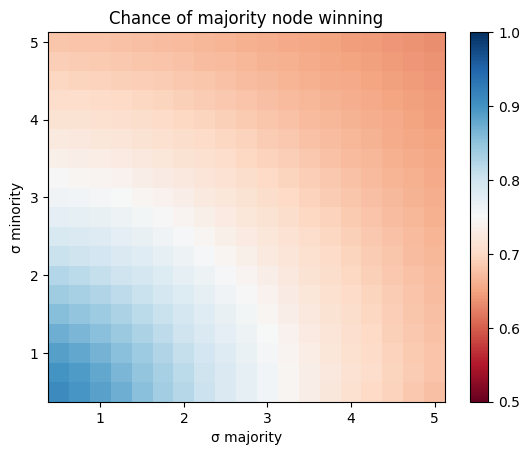

In [37]:
fig, ax = plt.subplots()
data = accuracy.loc[(accuracy.sigma_maj >= 0.5) & (accuracy.sigma_min >= 0.5)]
c = ax.pcolormesh(np.arange(0.5,5.25,0.25), np.arange(0.5,5.25,0.25), np.array(data['prob majority winning']).reshape(19, 19), cmap='RdBu', vmin=0.5, vmax=1)
ax.set_title('Chance of majority node winning')
ax.set_xlabel('σ majority') #σ, μ
ax.set_ylabel('σ minority')
fig.colorbar(c, ax=ax)
plt.show()

## Ground-Truth Distribution + Bias Distribution

In [3]:
# Optimize parameters of two normal distributions:
# basic scores for the whole population; bias added to unpriviledged group's scores
# -> fix mean of basic scores (priviledged group) at 0
# -> fix variance of bias distribution at 1

res = minimize_parallel(get_normal_loss_bias_constraint, x0=[5,-1], args=(0.7, 0.9, 0, 1), bounds=[(0.1,10),(-10,0)])

/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [4]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.608488277588738e-09
        x: [ 3.550e+00 -2.844e+00]
      nit: 27
      jac: [-1.084e-02  2.135e-02]
     nfev: 59
     njev: 59
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [7]:
x = [0] + list(res.x) + [1]
get_sep_probs_normal_bias(*x)

/opt/homebrew/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(0.6999999998211364, 0.8999999984014875)

In [8]:
### sanity check – simulate using the parameters obtained from optimization

rng = np.random.default_rng()
bias = rng.normal(loc=x[2], scale=x[3], size=10000000)
scores = rng.normal(loc=x[0], scale=x[1], size=10000000)

scores_min = scores + bias
rng.shuffle(scores_min) # if we don't shuffle, majority chances are overestimated!
scores_maj = scores

scores_i = np.concatenate([scores_min, scores_maj])
scores_j = scores_i.copy()
rng.shuffle(scores_j)
probs = pd.DataFrame(np.matrix([scores_i, scores_j]).transpose(), columns=['i\'s score', 'j\'s score'])
probs['prob j winning'] = 1 / (1 + np.exp(probs['i\'s score'] - probs['j\'s score']))
probs['prob i winning'] = 1 - probs['prob j winning']
probs['prob stronger winning'] = probs[['prob i winning', 'prob j winning']].max(axis=1)
print('prob of stronger candidate winning:', probs['prob stronger winning'].mean())

probs = pd.DataFrame(np.matrix([scores_min, scores_maj]).transpose(), columns=['min\'s score', 'maj\'s score'])
probs['prob maj winning'] = 1 / (1 + np.exp(probs['min\'s score'] - probs['maj\'s score']))
print('prob of majority candidate winning:', probs['prob maj winning'].mean())

prob of stronger candidate winning: 0.903499931511754
prob of majority candidate winning: 0.6999065163044398
